In [8]:
# Imported libraries
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib as mpl
import imageio
import cv2
import sys
import os
import pickle

In [9]:
# Place directory paths and declare needed
# variables for initiating the general categorization
# and storing of patient scans arrays

original_directory_path = '/media/omar/New Volume/TCIA Data/GBM/Data/TCGA-GBM/'
segmented_directory_path = '/home/omar/Desktop/DropboxData/Dropbox-GBM/TCGA-GBM/'
result_directory_path = '/home/omar/Desktop/TrainingResult_dup/'
patients = []

"""

Patient pickle file structure
File Name: Patient ID (TCGA-xx-xxxx)
DATA:
[
    [sorted original 23 arrays of AX T2],
    [sorted original 23 arrays of AX T1],
    [sorted original 23 arrays of FLAIR],
    [sorted original 23 arrays of POST],
    [segmentation array]

]

"""


# Get all the patient IDs that will be used for the training phase and sort them
for patient in os.listdir(segmented_directory_path):
    patients.append(patient)
patients.sort()
# We now have a list of all the patients needed for the training phase
# print (patients)

In [10]:
# Problems log, updates and status
"""
    
    Retreiving files of the original patient scans for designated scan
    Problems occured:
    1- Not all patient directories have single scan history
    Patients with such issue are: 06-0138, 19-5960.
    Resolved by validating ID for every scan
    Status: Resolved by defining an aiding module 'multipleVisits' that operates in the else statement
    
    if(one visit)-> undergo the process of retreiving patient scans images
    else -> use the 'multipleVisits' module to identify the visit date containing scans
            segmented followed by retreiving patient data
                
    Another problem to be handled
    2- Second problem is the sorting of the original scans dicom files.
    The files are named 0000-0023. However they aren't aligned in order through
    that naming, instead there is a dicom object attribute called
    InstanceNumber that identifies the order of the scans.
    Status: An aiding function 'dicomSort' was declared to handle this issue.
                
    
    A third problem occured
    3- Some of the original scans aren't of the usual dimensions (256,256)
    but rather (512,512). Problem discovered at
    Patient: TCGA-06-0138
    Visit Date: 11-25-2002-91840
    Scan: 10-AX T1 POST GD FLAIR-87338
    Dicom: 000000.dcm
    UNKNOWN IF SAME ISSUE OCCURS AT OTHER PLACES ALTHOUGH ITS LIKELY FOR THE SAME PATIENT
    
    Problem discovered when storing the original scan arrays in an already
    initialized original_scans npArray of zeroes that was initialized with
    the dimensions (256,256)
    --------------------------------------------------------------------------
    Status: function imageArray declared in the testing area was supposed to handle this
    but halted for now.
                
    
    """
"----------------------------------------"

'----------------------------------------'

In [11]:
# Aiding modules and functions
"""
    Module to handle the existence of subfolders for multiple patient visits
    Purpose and working principle:
    Iterates over the original patient subfolders till it finds scan folders relevant by scan ID
    Inputs are, patient ID and an array containing
    the segmentation filenames in the form 'seg_corrected_AX-*****.dcm'
    Returns the subfolders containing the relevant original scans (usually one folder)"""

def multipleVisits(patient_id, segmented_scans):
    subfolders = os.listdir(original_directory_path+patient_id)
    segmented_ids = []
    for i in segmented_scans:
        segmented_ids.append(i[-9:-4])
    target_folders = []
    for folder in subfolders:
        images_folder = os.listdir(original_directory_path+patient_id+"/"+folder)
        for scans in images_folder:
            if scans[-5:] in segmented_ids and folder not in target_folders:
                target_folders.append(folder)
    return target_folders

"""
    Module to handle the issue with sorting of the original dicom files of the
    patient because the filenames are in no way sorted either. The working principle
    of the function is that it takes in an array of filenames and returns a dictionary
    where key is the instance number and the value is the correspondent file name.
    The keys are sorted to make the appending the original patient data in the pickle 
    file be in the correct order
"""

def dicomSort(path_to_scans, file_array):
    dicom_sorting = {}
    for file in range(len(file_array)):
        instance = pydicom.dcmread(path_to_scans + "/" + file_array[file])
        instance_value = instance.InstanceNumber
        dicom_sorting[instance_value] = file_array[file]
    sorted(dicom_sorting.keys())
    return dicom_sorting


"""
    Module to traverse the scan segmentation dicom file and export slice arrays
    to be added to the respective patient pickle data file. It should be generic
    and not limited to only 23 slices after learning that not all patients have 23
    slices only.
"""


def segmentationArray(path_to_scan, file):
    ds = pydicom.dcmread(path_to_scan+"/"+file).pixel_array
    number_of_slices = ds.shape[0]
    big_range = (int)(number_of_slices/3)   
    tumor_core = ds[0:big_range,:,:]
    edema = ds[big_range:(big_range*2),:,:]
    non_enhanced_tumor = ds[(big_range*2):,:,:]
    unified_label = tumor_core + edema + non_enhanced_tumor
    unified_label = np.swapaxes(unified_label,0,2)
    
    return unified_label

In [12]:
"""

After having the training patients recognized, we now need to start
creating pickle files for every patient to store the data at

Pickle file Information
Name: Patient
Data included:
a. original scan images
b. arrays for each of the segmented scans

"""


os.chdir(result_directory_path)

for patient_id in patients:
#     Getting the corrected segmented scan filenames for every patient (ID at indexing -9:-4)
    patient_segmented_files = []
    for scan in os.listdir(segmented_directory_path+patient_id+'/DSO/'):
        if "corrected" in scan:
            patient_segmented_files.append(scan)
    
#     Pickle file for patient initialized
    pickleFile = open("%s.pickle" % (patient_id) ,"wb")
#     Data Array for patient initialized
    data_array = []
    segmented_ids = []
    for dcm in patient_segmented_files:
        segmented_ids.append(dcm[-9:-4])
    
    """
    
    Retreiving files of the original patient scans for designated scan
    Problems occured:
    1- Not all patient directories have single scan history
    Patients with such issue are: 06-0138, 19-5960.
    Resolved by validating ID for every scan
    Status: Resolved by defining an aiding module 'multipleVisits' that operates in the else statement
    
    if(one visit)-> undergo the process of retreiving patient scans images
    else -> use the 'multipleVisits' module to identify the visit date containing scans
            segmented followed by retreiving patient data
    
    """
    
    
    
    if(len(os.listdir(original_directory_path+patient_id)) == 1):
#         If only one visit for the patient
        visit_date = os.listdir(original_directory_path+patient_id)[0]
        seg_data_array = []
        for scan_directory in os.listdir(original_directory_path+patient_id+"/"+visit_date):
#             Scan directory is the level in which scan type folders of that visit is reached
#             if any(scan_directory[-5:] in segment_scan for segment_scan in patient_segmented_files):
            if scan_directory[-5:] in segmented_ids:
#                 Handling segmentation data first and then the original
                seg_index = 0
                for index, name in enumerate(patient_segmented_files):
                    if scan_directory[-5:] in name:
                        seg_index = index
                path_to_seg = segmented_directory_path+patient_id+"/DSO"
                seg_data_array.append(segmentationArray(path_to_seg, patient_segmented_files[seg_index]))
#                 Segmented Data appended to array, now original
                folder_containing_scans = scan_directory
                path_for_scans = original_directory_path+patient_id+"/"+visit_date+"/"+folder_containing_scans
                scan_array = []
                images = os.listdir(path_for_scans)                
                ordered_dict_of_filenames = dicomSort(path_for_scans, images)
                for image in sorted(ordered_dict_of_filenames.keys()):
                    ds = pydicom.dcmread(path_for_scans+"/"+ordered_dict_of_filenames[image]).pixel_array
                    scan_array.append(ds)
                    
                data_array.append(scan_array)
        data_array.append(seg_data_array)
        pickle.dump(data_array,pickleFile)
        pickleFile.close()
        
        
#     In case of having multiple visits by the patient
    else:
        folder_containing_scans = multipleVisits(patient_id, patient_segmented_files)
        for folder in folder_containing_scans:
            visit_date = folder
        seg_data_array = []
        for scan_directory in os.listdir(original_directory_path+patient_id+"/"+visit_date):
#             if any(scan_directory[-5:] in segment_scan for segment_scan in patient_segmented_files):
            if scan_directory[-5:] in segmented_ids:
                seg_index = 0
                for index, name in enumerate(patient_segmented_files):
                    if scan_directory[-5:] in name:
                        seg_index = index
                path_to_seg = segmented_directory_path+patient_id+"/DSO"
                seg_data_array.append(segmentationArray(path_to_seg, patient_segmented_files[seg_index]))
                
                
                folder_containing_scans = scan_directory
                path_for_scans = original_directory_path+patient_id+"/"+visit_date+"/"+folder_containing_scans
                scan_array = []
                images = os.listdir(path_for_scans)
                ordered_dict_of_filenames = dicomSort(path_for_scans, images)
                for image in sorted(ordered_dict_of_filenames.keys()):
                    ds = pydicom.dcmread(path_for_scans+"/"+ordered_dict_of_filenames[image]).pixel_array
                    scan_array.append(ds)
                data_array.append(scan_array)
        data_array.append(seg_data_array)
        pickle.dump(data_array,pickleFile)
        pickleFile.close()                


In [27]:
# Completed so far, pickle for gathering all designated original data scans for every segmentation
# scan has been completed. Testing for results. Anomalies detected with multiple
# with extra number of scans
# The final data array contains all the original patient scans and their respective segmentation
# The code below tests for one patient. Further confirmation is essential for the model training phase!

4


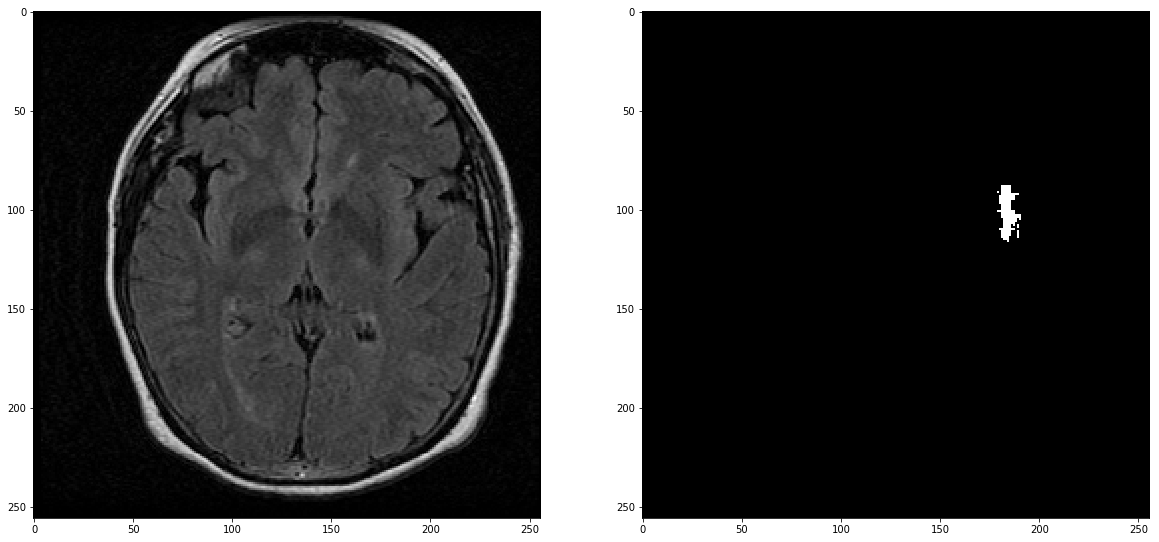

In [33]:
result_files = os.listdir(result_directory_path)
file = 'TCGA-02-0006.pickle'
patient = open("%s" % (result_directory_path+file), "rb")
patient_data = pickle.load(patient)
# for i in patient_data:
# print(len(patient_data))
# for arrays in patient_data[1]:

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.squeeze(patient_data[1][11]), 'gray')
plt.subplot(122)
plt.imshow(np.squeeze(patient_data[4][1][:,:,11]), 'gray')
#     break
#     plt.savefig("%s.png" %(imgName), dpi=300, bbox_inches = 'tight', nbins=0, pad_inches=0)
#     plt.show()
print(len(patient_data[4]))

# for seg_array in patient_data[4]:
#     plt.figure(figsize=(20,10))
#     plt.imshow(np.squeeze(seg_array[:,:,4]),'gray')
#     break
    